<a href="https://colab.research.google.com/github/Eran-BA/ART/blob/main/gpu_utilization_pot_alibaba_vanilla_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU Utilization Prediction with PoT HybridHRM

**Architecture**: Transformer controller + Broadcast injection + HRM gradient style

**Config**: [broadcast_transformer_last.ipynb](https://github.com/Eran-BA/PoT/blob/main/notebooks/broadcast_transformer_last.ipynb)

## 🏆 State-of-the-Art on Alibaba GPU Trace v2020

| Model | Architecture | RMSE | MAE | R² | Notes |
|-------|--------------|------|-----|-----|-------|
| **MSHGN** (Wang 2024) | Hierarchical GCN | **0.010** | **0.007** | N/R | MAPE=6.41% |
| **DGCLA-Transformer** (Xu 2025) | Transformer + Gating | 0.074-0.24 | N/R | N/R | 91% task classification |
| **ASM + ST-LSTM** (Wang 2025) | Selection + LSTM | 1.84 | 1.09 | N/R | 87% GPU type accuracy |
| **Feature-Correlation** (Wang 2024) | Correlation-based | 7.08 | 3.81 | **0.93** | [Paper](https://doi.org/10.1007/s11227-023-05807-x) |
| **PoT HybridHRM** (Ours) | Transformer + Broadcast | TBD | TBD | TBD | Iterative reasoning |

*N/R = Not Reported*

## Dataset: Alibaba Cluster Trace GPU v2020

- **1,800+ nodes**, **6,700+ GPUs** (4 types)
- **1.2M+ tasks**, **7.5M instances**
- **2 months** (July-August 2020)

📥 **Download** (auto in Colab, or run locally):
```bash
git clone https://github.com/alibaba/clusterdata.git
cd clusterdata/cluster-trace-gpu-v2020/data && bash download_data.sh
```

In [1]:
# 🚀 COLAB SETUP
import sys, os

IN_COLAB = 'google.colab' in sys.modules

# ============================================================
# SET THIS BEFORE RUNNING (also set in cell 2)
# ============================================================
DATASET_TO_DOWNLOAD = "v2020"  # "v2025" (quick) or "v2020" (full benchmark)

if IN_COLAB:
    print("🔧 Setting up Colab...")
    from google.colab import userdata
    GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
    GITHUB_USER = "Eran-BA"

    # Install dependencies
    !pip install torch scikit-learn tqdm matplotlib pandas numpy wandb kagglehub -q

    # Clone repos
    !rm -rf /content/SymbolicRouter /content/PoT
    !git clone https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/SymbolicRouter.git /content/SymbolicRouter
    !git clone https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/PoT.git /content/PoT

    # Download dataset based on choice
    if DATASET_TO_DOWNLOAD == "v2020":
        print("📥 Downloading Alibaba GPU v2020 (official, ~1.2M samples)...")
        !rm -rf /content/clusterdata
        !git clone --depth 1 https://github.com/alibaba/clusterdata.git /content/clusterdata
        %cd /content/clusterdata/cluster-trace-gpu-v2020/data
        !bash download_data.sh
        !tar -xzf pai_task_table.tar.gz 2>/dev/null || echo "Extracting..."
        print("✓ v2020 ready")
    else:
        print("📥 Using Kaggle v2025 (auto-downloaded via kagglehub)")

    os.chdir('/content/SymbolicRouter')
    sys.path.insert(0, '/content/SymbolicRouter')
    sys.path.insert(0, '/content/PoT/src')
    print("✓ Setup complete!")
else:
    print("Running locally")

🔧 Setting up Colab...
Cloning into '/content/SymbolicRouter'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 226 (delta 7), reused 14 (delta 6), pack-reused 209 (from 1)
Receiving objects: 100% (226/226), 641.19 KiB | 2.56 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Cloning into '/content/PoT'...
remote: Enumerating objects: 3442, done.
remote: Total 3442 (delta 0), reused 0 (delta 0), pack-reused 3442 (from 2)
Receiving objects: 100% (3442/3442), 2.80 MiB | 6.44 MiB/s, done.
Resolving deltas: 100% (2287/2287), done.
📥 Downloading Alibaba GPU v2020 (official, ~1.2M samples)...
Cloning into '/content/clusterdata'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 149 (delta 10), reused 130 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (149/149), 37.89 MiB | 26.

In [6]:
# Imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from src.model import GPUMemoryHybridHRM, create_model
from src.model_11cell import GPUMemory11Cell, create_11cell_model
from src.baseline_transformer import VanillaTransformerRegressor, create_baseline_transformer
from src.data import load_alibaba_gpu_data, create_dataloaders
from src.train import train_with_wandb

# Settings
USE_WANDB = True  # Set to False to disable

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# ============================================================
# CONFIGURATION: Choose dataset and model
# ============================================================

# DATASET OPTIONS:
#   "v2025"  - Kaggle dataset (23K samples, easier, quick experiments)
#   "v2020"  - Official Alibaba (1.2M samples, harder, for benchmarking)
DATASET = "v2020"  # <-- CHANGE THIS

# MODEL OPTIONS:
#   "vanilla_lite"  - Baseline (8M params, no PoT) - same size as PoT Lite
#   "vanilla_full"  - Baseline (32M params, no PoT) - same size as PoT Full
#   "1token_lite"   - PoT 1-token (8M params)
#   "1token_full"   - PoT 1-token (32M params)
#   "11cell_lite"   - PoT 11-cell Nash (8M params, 3 losses)
#   "11cell_full"   - PoT 11-cell Nash (32M params, 3 losses)
#   "no_injection"  - PoT ablation (no injection)
MODEL_CONFIG = "vanilla_lite"  # <-- CHANGE THIS

# 1-Token Configs (original architecture)
CONFIG_1TOKEN_FULL = {  # ~32M params
    "arch": "1token",
    "d_model": 512, "d_ff": 2048, "n_heads": 8, "dropout": 0.039,
    "controller_type": "transformer", "d_ctrl": 256, "max_depth": 32,
    "injection_mode": "broadcast",
    "H_cycles": 2, "L_cycles": 6, "H_layers": 2, "L_layers": 2,
    "hrm_grad_style": True, "halt_max_steps": 2,
    "batch_size": 64, "learning_rate": 3e-4, "weight_decay": 0.01, "epochs": 100,
}

CONFIG_1TOKEN_LITE = {  # ~8M params
    "arch": "1token",
    "d_model": 256, "d_ff": 1024, "n_heads": 4, "dropout": 0.05,
    "controller_type": "transformer", "d_ctrl": 128, "max_depth": 16,
    "injection_mode": "broadcast",
    "H_cycles": 2, "L_cycles": 6, "H_layers": 2, "L_layers": 2,
    "hrm_grad_style": True, "halt_max_steps": 2,
    "batch_size": 128, "learning_rate": 5e-4, "weight_decay": 0.01, "epochs": 100,
}

# 11-Cell Configs (Nash equilibrium - like Sudoku!)
CONFIG_11CELL_FULL = {  # ~32M params + 3 losses
    "arch": "11cell",
    "d_model": 512, "d_ff": 2048, "n_heads": 8, "dropout": 0.039,
    "controller_type": "transformer", "d_ctrl": 256, "max_depth": 32,
    "injection_mode": "broadcast",
    "H_cycles": 2, "L_cycles": 6, "H_layers": 2, "L_layers": 2,
    "hrm_grad_style": True, "halt_max_steps": 2,
    "batch_size": 64, "learning_rate": 3e-4, "weight_decay": 0.01, "epochs": 100,
    # Q-loss weights for ACT
    "q_halt_weight": 0.1, "q_continue_weight": 0.1, "error_threshold": 0.1,
}

CONFIG_11CELL_LITE = {  # ~8M params + 3 losses
    "arch": "11cell",
    "d_model": 256, "d_ff": 1024, "n_heads": 4, "dropout": 0.05,
    "controller_type": "transformer", "d_ctrl": 128, "max_depth": 16,
    "injection_mode": "broadcast",
    "H_cycles": 2, "L_cycles": 6, "H_layers": 2, "L_layers": 2,
    "hrm_grad_style": True, "halt_max_steps": 2,
    "batch_size": 128, "learning_rate": 5e-4, "weight_decay": 0.01, "epochs": 100,
    # Q-loss weights for ACT
    "q_halt_weight": 0.1, "q_continue_weight": 0.1, "error_threshold": 0.1,
}

CONFIG_NO_INJECTION = {  # ~30M params - ablation
    "arch": "1token",
    "d_model": 512, "d_ff": 2048, "n_heads": 8, "dropout": 0.039,
    "controller_type": "transformer", "d_ctrl": 256, "max_depth": 32,
    "injection_mode": "none",
    "H_cycles": 2, "L_cycles": 6, "H_layers": 2, "L_layers": 2,
    "hrm_grad_style": True, "halt_max_steps": 2,
    "batch_size": 64, "learning_rate": 3e-4, "weight_decay": 0.01, "epochs": 100,
}

# Vanilla Transformer Baselines (NO PoT - same param counts for fair comparison)
# NOTE: v2020 needs more epochs (100) and lower LR than v2025
CONFIG_VANILLA_LITE = {  # ~8M params - same as PoT Lite
    "arch": "vanilla",
    "d_model": 320, "d_ff": 1280, "n_heads": 8, "n_layers": 6, "dropout": 0.1,
    "batch_size": 256, "learning_rate": 1e-4, "weight_decay": 0.01,
    "epochs": 100 if DATASET == "v2020" else 30,  # v2020 needs more epochs
}

CONFIG_VANILLA_FULL = {  # ~32M params - same as PoT Full
    "arch": "vanilla",
    "d_model": 512, "d_ff": 2048, "n_heads": 8, "n_layers": 10, "dropout": 0.1,
    "batch_size": 128, "learning_rate": 3e-4, "weight_decay": 0.01,
    "epochs": 100 if DATASET == "v2020" else 30,
}

CONFIGS = {
    "vanilla_lite": CONFIG_VANILLA_LITE,
    "vanilla_full": CONFIG_VANILLA_FULL,
    "1token_full": CONFIG_1TOKEN_FULL,
    "1token_lite": CONFIG_1TOKEN_LITE,
    "11cell_full": CONFIG_11CELL_FULL,
    "11cell_lite": CONFIG_11CELL_LITE,
    "no_injection": CONFIG_NO_INJECTION,
    # Aliases
    "full": CONFIG_1TOKEN_FULL,
    "lite": CONFIG_1TOKEN_LITE,
}
CONFIG = CONFIGS[MODEL_CONFIG]
arch = CONFIG.get("arch", "1token")
print(f"🔧 Config: {MODEL_CONFIG.upper()}")
print(f"   Architecture: {arch} | d_model={CONFIG['d_model']}")
if arch == "vanilla":
    print(f"   📊 Vanilla Transformer baseline (NO PoT, {CONFIG['n_layers']} layers)")
elif arch == "11cell":
    print(f"   📊 Using 3 losses: Main (MSE) + Q-halt + Q-continue (like Sudoku)")
else:
    print(f"   📊 PoT 1-token with injection={CONFIG.get('injection_mode', 'broadcast')}")

Device: cuda
🔧 Config: VANILLA_LITE
   Architecture: vanilla | d_model=320
   📊 Vanilla Transformer baseline (NO PoT, 6 layers)


In [7]:
# Load Data - Configurable dataset
# ============================================================
# DATASET is set above: "v2025" (Kaggle) or "v2020" (Official)
# ============================================================

if DATASET == "v2020":
    # Official Alibaba v2020 (same as Wang et al. 2024)
    DATA_DIR = "/content/clusterdata/cluster-trace-gpu-v2020/data"  # Colab
    # Local: DATA_DIR = os.path.expanduser("~/clusterdata/cluster-trace-gpu-v2020/data")
    print(f"📥 Loading Alibaba v2020 (official) from {DATA_DIR}")
    X, y, X_mean, X_std, y_min, y_max, feature_cols = load_alibaba_gpu_data(
        dataset="v2020", data_dir=DATA_DIR
    )
else:
    # Kaggle v2025 (quick experiments)
    print("📥 Loading Alibaba v2025 (Kaggle)")
    X, y, X_mean, X_std, y_min, y_max, feature_cols = load_alibaba_gpu_data(
        dataset="kaggle"
    )

# 3-way split: Train (70%) / Val (15%) / Test (15%)
train_loader, val_loader, test_loader = create_dataloaders(
    X, y,
    batch_size=CONFIG['batch_size'],
    val_split=0.15,
    test_split=0.15,
)

print(f"\n✓ Dataset: {DATASET.upper()}")
print(f"✓ Features: {len(feature_cols)}, Samples: {len(X):,}")
print(f"✓ Target range: [{y_min:.0f}, {y_max:.0f}]")
print(f"✓ Split: Train/Val/Test = 70%/15%/15%")

📥 Loading Alibaba v2020 (official) from /content/clusterdata/cluster-trace-gpu-v2020/data
📥 Loading Alibaba v2020 from /content/clusterdata/cluster-trace-gpu-v2020/data...
Loading: /content/clusterdata/cluster-trace-gpu-v2020/data/pai_task_table.csv
Loaded 1,261,050 rows
Columns: ['task_name', 'workload_type', 'inst_num', 'status', 'start_time', 'end_time', 'plan_cpu', 'plan_mem', 'plan_gpu', 'gpu_type']
After cleaning: 1,037,085 rows
GPU types: {'MISC': 693598, 'T4': 225991, 'P100': 71344, 'V100': 28144, 'V100M32': 18007}
After cleaning: 1037085 rows

Features (5):
  0: plan_cpu
  1: plan_gpu
  2: inst_num
  3: gpu_type_encoded
  4: workload_encoded

Target: plan_mem
Range: [0, 400]

Dataloaders: Train=725961, Val=155562, Test=155562

✓ Dataset: V2020
✓ Features: 5, Samples: 1,037,085
✓ Target range: [0, 400]
✓ Split: Train/Val/Test = 70%/15%/15%


In [8]:
# Create Model based on architecture
arch = CONFIG.get("arch", "1token")

if arch == "vanilla":
    # Vanilla Transformer baseline (no PoT) - same param count as PoT
    model = create_baseline_transformer(input_dim=len(feature_cols), config=CONFIG, device=device)
    print(f"🎯 Vanilla Transformer: Baseline ({CONFIG['n_layers']} layers, no PoT iterations)")
elif arch == "11cell":
    # 11-cell architecture (Nash equilibrium, 3 losses)
    model = create_11cell_model(n_features=len(feature_cols), config=CONFIG, device=device)
    print("🎯 11-cell: 10 features + 1 mask = 11 cells (like Sudoku)")
else:
    # 1-token architecture (original)
    model = create_model(input_dim=len(feature_cols), config=CONFIG, device=device)
    print("🎯 1-token: All features → single token")

print(f"Parameters: {model.count_parameters():,} ({model.count_parameters()/1e6:.2f}M)")

Created VanillaTransformerRegressor: 7,451,841 params
🎯 Vanilla Transformer: Baseline (6 layers, no PoT iterations)
Parameters: 7,451,841 (7.45M)


In [9]:
# Train - Works for all architectures (vanilla, 1token, 11cell)
import torch.optim as optim
from tqdm import tqdm
import wandb

# ============================================================
# RESUME FROM W&B - Set this to continue from previous run
# ============================================================
RESUME_FROM = None  # e.g.: "your-entity/pot-gpu-prediction/model-best:latest"

arch = CONFIG.get("arch", "1token")
use_3_losses = (arch == "11cell")  # Only 11-cell uses 3 losses

# Initialize W&B
if USE_WANDB:
    if arch == "vanilla":
        run_name = f"vanilla-{DATASET}-{CONFIG['d_model']}d-{CONFIG['n_layers']}L"
    else:
        run_name = f"{arch}-{DATASET}-halt{CONFIG['halt_max_steps']}-H{CONFIG['H_cycles']}-L{CONFIG['L_cycles']}"
    wandb.init(project="pot-gpu-prediction", name=run_name, config=CONFIG)

optimizer = optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])
criterion = nn.MSELoss()
best_val_r2 = 0
start_epoch = 0
history = {"train_loss": [], "val_loss": [], "val_r2": []}
if use_3_losses:
    history.update({"main_loss": [], "q_halt": [], "q_continue": []})

# Resume from W&B checkpoint
if RESUME_FROM and USE_WANDB:
    print(f"📥 Resuming from: {RESUME_FROM}")
    artifact = wandb.use_artifact(RESUME_FROM, type='model')
    artifact_dir = artifact.download()
    checkpoint = torch.load(f"{artifact_dir}/model.pt", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint.get('epoch', 0)
    best_val_r2 = checkpoint.get('val_r2', 0)
    print(f"✓ Resumed from epoch {start_epoch}, R²={best_val_r2:.4f}")

print(f"\n🚀 Training on {DATASET.upper()} for {CONFIG['epochs']} epochs")
if arch == "vanilla":
    print(f"   Model: Vanilla Transformer ({CONFIG['n_layers']} layers, {model.count_parameters()/1e6:.1f}M params)")
else:
    print(f"   Model: {arch} | halt_max={CONFIG.get('halt_max_steps', 'N/A')}, H={CONFIG.get('H_cycles', 'N/A')}, L={CONFIG.get('L_cycles', 'N/A')}")
if use_3_losses:
    print("   📊 Using 3 losses: Main (MSE) + Q-halt + Q-continue")

for epoch in range(CONFIG["epochs"]):
    global_epoch = start_epoch + epoch + 1

    # Train
    model.train()
    train_loss, main_loss, q_halt_loss, q_continue_loss = 0, 0, 0, 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {global_epoch}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        if use_3_losses:
            losses = model.compute_loss(xb, yb,
                q_halt_weight=CONFIG.get("q_halt_weight", 0.1),
                q_continue_weight=CONFIG.get("q_continue_weight", 0.1),
                error_threshold=CONFIG.get("error_threshold", 0.1))
            loss = losses["total"]
            main_loss += losses["main"].item()
            q_halt_loss += losses["q_halt"].item()
            q_continue_loss += losses["q_continue"].item()
        else:
            loss = criterion(model(xb), yb)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()

    n = len(train_loader)
    train_loss /= n

    # Validate
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            val_preds.extend(model(xb.to(device)).cpu().numpy())
            val_targets.extend(yb.numpy())

    val_loss = mean_squared_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_r2"].append(val_r2)

    if use_3_losses:
        history["main_loss"].append(main_loss / n)
        history["q_halt"].append(q_halt_loss / n)
        history["q_continue"].append(q_continue_loss / n)

    # Log to W&B
    if USE_WANDB:
        log_dict = {
            "epoch": global_epoch, "train_loss": train_loss,
            "val_loss": val_loss, "val_r2": val_r2,
        }
        if use_3_losses:
            log_dict.update({
                "main_loss": main_loss / n,
                "q_halt": q_halt_loss / n,
                "q_continue": q_continue_loss / n,
            })
        wandb.log(log_dict)

    # Save best model
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(model.state_dict(), "best_model.pt")
        if USE_WANDB:
            checkpoint = {
                'epoch': global_epoch, 'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(), 'val_r2': val_r2, 'config': CONFIG,
            }
            torch.save(checkpoint, "checkpoint.pt")
            artifact = wandb.Artifact('model-best', type='model')
            artifact.add_file("checkpoint.pt", name="model.pt")
            wandb.log_artifact(artifact)
            print(f"  💾 New best: R²={val_r2:.4f} → saved to W&B")

    if (epoch + 1) % 10 == 0 or epoch == 0:
        if use_3_losses:
            print(f"Epoch {global_epoch:3d} | Main: {main_loss/n:.4f} | Q_h: {q_halt_loss/n:.4f} | Q_c: {q_continue_loss/n:.4f} | R²: {val_r2:.4f}")
        else:
            print(f"Epoch {global_epoch:3d} | Loss: {train_loss:.4f} | R²: {val_r2:.4f}")

# Final test evaluation
print(f"\n🏆 Best Val R²: {best_val_r2:.4f}")
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        test_preds.extend(model(xb.to(device)).cpu().numpy())
        test_targets.extend(yb.numpy())
test_r2 = r2_score(test_targets, test_preds)
print(f"🎯 FINAL TEST R²: {test_r2:.4f} (on held-out test set)")
history["test_r2"] = test_r2

if USE_WANDB:
    wandb.log({"test_r2": test_r2})
    wandb.finish()

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,▁▄█████████████
val_loss,▁██████████████
val_r2,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
train_loss,0.00235
val_loss,0.00245
val_r2,-0.00014



🚀 Training on V2020 for 100 epochs
   Model: Vanilla Transformer (6 layers, 7.5M params)


  💾 New best: R²=0.6949 → saved to W&B
Epoch   1 | Loss: 0.0011 | R²: 0.6949


  💾 New best: R²=0.7468 → saved to W&B


  💾 New best: R²=0.7476 → saved to W&B


  💾 New best: R²=0.7543 → saved to W&B


  💾 New best: R²=0.7664 → saved to W&B


  💾 New best: R²=0.7897 → saved to W&B


  💾 New best: R²=0.8083 → saved to W&B


  💾 New best: R²=0.8171 → saved to W&B
Epoch  10 | Loss: 0.0006 | R²: 0.8171


Epoch  20 | Loss: 0.0006 | R²: 0.8041


  💾 New best: R²=0.8213 → saved to W&B


  💾 New best: R²=0.8266 → saved to W&B


  💾 New best: R²=0.8296 → saved to W&B


Epoch  30 | Loss: 0.0005 | R²: 0.8218


  💾 New best: R²=0.8312 → saved to W&B


  💾 New best: R²=0.8337 → saved to W&B
Epoch  40 | Loss: 0.0005 | R²: 0.8337


  💾 New best: R²=0.8352 → saved to W&B


  💾 New best: R²=0.8367 → saved to W&B


  💾 New best: R²=0.8433 → saved to W&B
Epoch  50 | Loss: 0.0004 | R²: 0.8433


  💾 New best: R²=0.8448 → saved to W&B
Epoch  60 | Loss: 0.0004 | R²: 0.8448


  💾 New best: R²=0.8496 → saved to W&B


  💾 New best: R²=0.8506 → saved to W&B


Epoch  70 | Loss: 0.0005 | R²: 0.7831


Epoch  80 | Loss: 0.0004 | R²: 0.8480


  💾 New best: R²=0.8509 → saved to W&B


  💾 New best: R²=0.8530 → saved to W&B


  💾 New best: R²=0.8537 → saved to W&B


  💾 New best: R²=0.8579 → saved to W&B


  💾 New best: R²=0.8580 → saved to W&B
Epoch  90 | Loss: 0.0004 | R²: 0.8580


  💾 New best: R²=0.8586 → saved to W&B


Epoch 100 | Loss: 0.0004 | R²: 0.7256

🏆 Best Val R²: 0.8586
🎯 FINAL TEST R²: 0.7267 (on held-out test set)


epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
test_r2,▁
train_loss,▆▆▅▅█▄▄▄▆▄▄▃▄▃▃▂▃▃▃▃▂▃▂▂▂▂▂▂▂▃▂▁▂▁▂▁▁▁▂▂
val_loss,█▄▆▃▅▃▃▃▃▂▄▄▂▃▂▂▃▂▂▂▂▅▂▂▂▂▂▄▄▁▁▁▂▁▁▁▂▁▁▁
val_r2,▁▃▄▂▆▆▆▅▆▄▆▇▄▄▇▆▇▇▄▇▇▅██▅██▇▇██████▇▇██▂
epoch,100
test_r2,0.72674
train_loss,0.00043
val_loss,0.00067
val_r2,0.72557


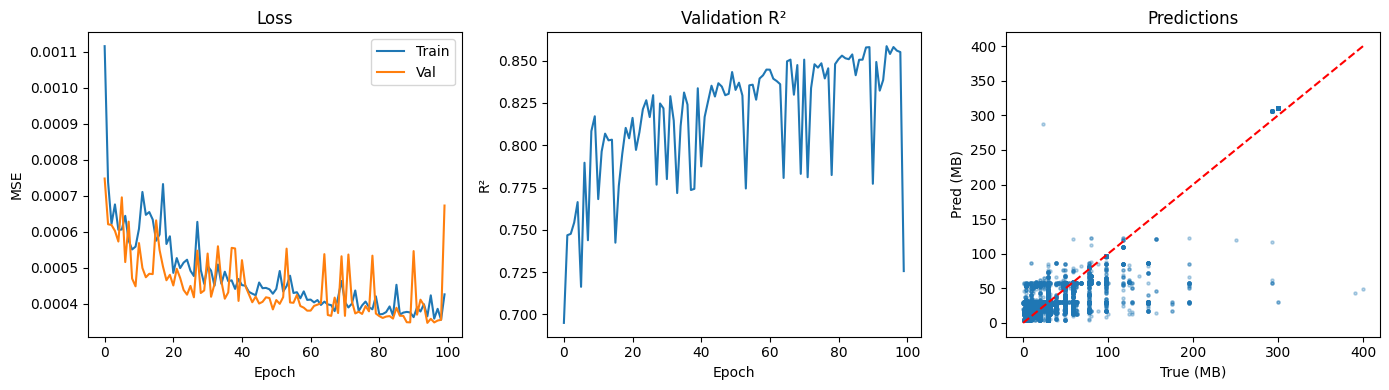


📊 Final: RMSE=7.4 MB, R²=0.8586


In [10]:
# Visualize Results
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["val_loss"], label="Val")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("MSE"); axes[0].legend(); axes[0].set_title("Loss")

axes[1].plot(history["val_r2"])
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("R²"); axes[1].set_title("Validation R²")

# Predictions
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        all_preds.extend(model(xb.to(device)).cpu().numpy())
        all_targets.extend(yb.numpy())
all_preds = np.array(all_preds) * (y_max - y_min) + y_min
all_targets = np.array(all_targets) * (y_max - y_min) + y_min

axes[2].scatter(all_targets, all_preds, alpha=0.3, s=5)
axes[2].plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
axes[2].set_xlabel("True (MB)"); axes[2].set_ylabel("Pred (MB)"); axes[2].set_title("Predictions")

plt.tight_layout(); plt.show()

print(f"\n📊 Final: RMSE={np.sqrt(mean_squared_error(all_targets, all_preds)):.1f} MB, R²={r2_score(all_targets, all_preds):.4f}")

## Manual Curriculum Learning

When you see convergence in W&B:

1. **Stop** the current run
2. **Update CONFIG** with new values:
```python
CONFIG["halt_max_steps"] = 3  # was 2
CONFIG["H_cycles"] = 4        # was 2
CONFIG["L_cycles"] = 12       # was 6
```
3. **Set RESUME_FROM** to your W&B artifact:
```python
RESUME_FROM = "your-entity/pot-gpu-prediction/model-best:latest"
```
4. **Re-run** the training cell

Best model is auto-saved to W&B as `model-best` artifact.

# lets resume

In [20]:
CONFIG_VANILLA_LITE

{'arch': 'vanilla',
 'd_model': 320,
 'd_ff': 1280,
 'n_heads': 8,
 'n_layers': 6,
 'dropout': 0.1,
 'batch_size': 256,
 'learning_rate': 0.0001,
 'weight_decay': 0.01,
 'epochs': 100}

In [21]:
# Train - Works for all architectures (vanilla, 1token, 11cell)
import torch.optim as optim
from tqdm import tqdm
import wandb

# ============================================================
# RESUME FROM W&B - Set this to continue from previous run
# ============================================================
MODEL_CONFIG = CONFIG_VANILLA_LITE  # or whatever you used for v68
MODEL_CONFIG['epochs'] = 2000
RESUME_FROM = "eranbt92-open-university-of-israel/pot-gpu-prediction/model-best:v76"

arch = CONFIG.get("arch", "1token")
use_3_losses = (arch == "11cell")  # Only 11-cell uses 3 losses

# Initialize W&B
if USE_WANDB:
    if arch == "vanilla":
        run_name = f"vanilla-{DATASET}-{CONFIG['d_model']}d-{CONFIG['n_layers']}L"
    else:
        run_name = f"{arch}-{DATASET}-halt{CONFIG['halt_max_steps']}-H{CONFIG['H_cycles']}-L{CONFIG['L_cycles']}"
    wandb.init(project="pot-gpu-prediction", name=run_name, config=CONFIG)

optimizer = optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])
criterion = nn.MSELoss()
best_val_r2 = 0
start_epoch = 0
history = {"train_loss": [], "val_loss": [], "val_r2": []}
if use_3_losses:
    history.update({"main_loss": [], "q_halt": [], "q_continue": []})

# Resume from W&B checkpoint
if RESUME_FROM and USE_WANDB:
    print(f"📥 Resuming from: {RESUME_FROM}")
    artifact = wandb.use_artifact(RESUME_FROM, type='model')
    artifact_dir = artifact.download()
    checkpoint = torch.load(f"{artifact_dir}/model.pt", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint.get('epoch', 0)
    best_val_r2 = checkpoint.get('val_r2', 0)
    print(f"✓ Resumed from epoch {start_epoch}, R²={best_val_r2:.4f}")

print(f"\n🚀 Training on {DATASET.upper()} for {CONFIG['epochs']} epochs")
if arch == "vanilla":
    print(f"   Model: Vanilla Transformer ({CONFIG['n_layers']} layers, {model.count_parameters()/1e6:.1f}M params)")
else:
    print(f"   Model: {arch} | halt_max={CONFIG.get('halt_max_steps', 'N/A')}, H={CONFIG.get('H_cycles', 'N/A')}, L={CONFIG.get('L_cycles', 'N/A')}")
if use_3_losses:
    print("   📊 Using 3 losses: Main (MSE) + Q-halt + Q-continue")

for epoch in range(CONFIG["epochs"]):
    global_epoch = start_epoch + epoch + 1

    # Train
    model.train()
    train_loss, main_loss, q_halt_loss, q_continue_loss = 0, 0, 0, 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {global_epoch}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        if use_3_losses:
            losses = model.compute_loss(xb, yb,
                q_halt_weight=CONFIG.get("q_halt_weight", 0.1),
                q_continue_weight=CONFIG.get("q_continue_weight", 0.1),
                error_threshold=CONFIG.get("error_threshold", 0.1))
            loss = losses["total"]
            main_loss += losses["main"].item()
            q_halt_loss += losses["q_halt"].item()
            q_continue_loss += losses["q_continue"].item()
        else:
            loss = criterion(model(xb), yb)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()

    n = len(train_loader)
    train_loss /= n

    # Validate
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            val_preds.extend(model(xb.to(device)).cpu().numpy())
            val_targets.extend(yb.numpy())

    val_loss = mean_squared_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_r2"].append(val_r2)

    if use_3_losses:
        history["main_loss"].append(main_loss / n)
        history["q_halt"].append(q_halt_loss / n)
        history["q_continue"].append(q_continue_loss / n)

    # Log to W&B
    if USE_WANDB:
        log_dict = {
            "epoch": global_epoch, "train_loss": train_loss,
            "val_loss": val_loss, "val_r2": val_r2,
        }
        if use_3_losses:
            log_dict.update({
                "main_loss": main_loss / n,
                "q_halt": q_halt_loss / n,
                "q_continue": q_continue_loss / n,
            })
        wandb.log(log_dict)

    # Save best model
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(model.state_dict(), "best_model.pt")
        if USE_WANDB:
            checkpoint = {
                'epoch': global_epoch, 'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(), 'val_r2': val_r2, 'config': CONFIG,
            }
            torch.save(checkpoint, "checkpoint.pt")
            artifact = wandb.Artifact('model-best', type='model')
            artifact.add_file("checkpoint.pt", name="model.pt")
            wandb.log_artifact(artifact)
            print(f"  💾 New best: R²={val_r2:.4f} → saved to W&B")

    if (epoch + 1) % 10 == 0 or epoch == 0:
        if use_3_losses:
            print(f"Epoch {global_epoch:3d} | Main: {main_loss/n:.4f} | Q_h: {q_halt_loss/n:.4f} | Q_c: {q_continue_loss/n:.4f} | R²: {val_r2:.4f}")
        else:
            print(f"Epoch {global_epoch:3d} | Loss: {train_loss:.4f} | R²: {val_r2:.4f}")

# Final test evaluation
print(f"\n🏆 Best Val R²: {best_val_r2:.4f}")
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        test_preds.extend(model(xb.to(device)).cpu().numpy())
        test_targets.extend(yb.numpy())
test_r2 = r2_score(test_targets, test_preds)
print(f"🎯 FINAL TEST R²: {test_r2:.4f} (on held-out test set)")
history["test_r2"] = test_r2

if USE_WANDB:
    wandb.log({"test_r2": test_r2})
    wandb.finish()

📥 Resuming from: eranbt92-open-university-of-israel/pot-gpu-prediction/model-best:v76


wandb: Downloading large artifact 'model-best:v76', 85.37MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.3 (274.3MB/s)


✓ Resumed from epoch 190, R²=0.8693

🚀 Training on V2020 for 2000 epochs
   Model: Vanilla Transformer (6 layers, 7.5M params)


Epoch 191 | Loss: 0.0003 | R²: 0.8568


Epoch 200 | Loss: 0.0004 | R²: 0.8502


Epoch 210 | Loss: 0.0003 | R²: 0.8629


Epoch 220 | Loss: 0.0004 | R²: 0.8655


  💾 New best: R²=0.8696 → saved to W&B


Epoch 230 | Loss: 0.0003 | R²: 0.8680


Epoch 240 | Loss: 0.0003 | R²: 0.8667


Epoch 250 | Loss: 0.0004 | R²: 0.8598


Epoch 260 | Loss: 0.0003 | R²: 0.8662


  💾 New best: R²=0.8715 → saved to W&B


Epoch 270 | Loss: 0.0003 | R²: 0.8659


  💾 New best: R²=0.8717 → saved to W&B


Epoch 280 | Loss: 0.0003 | R²: 0.8617


Epoch 290 | Loss: 0.0003 | R²: 0.8671


  💾 New best: R²=0.8717 → saved to W&B


  💾 New best: R²=0.8718 → saved to W&B


Epoch 300 | Loss: 0.0003 | R²: 0.8714


Epoch 310 | Loss: 0.0003 | R²: 0.8691


  💾 New best: R²=0.8719 → saved to W&B


Epoch 320 | Loss: 0.0003 | R²: 0.8584


Epoch 330 | Loss: 0.0003 | R²: 0.8717


  💾 New best: R²=0.8724 → saved to W&B


  💾 New best: R²=0.8726 → saved to W&B


Epoch 340 | Loss: 0.0003 | R²: 0.8668


Epoch 350 | Loss: 0.0003 | R²: 0.8652


Epoch 360 | Loss: 0.0004 | R²: 0.8517


Epoch 370 | Loss: 0.0003 | R²: 0.8684


Epoch 380 | Loss: 0.0003 | R²: 0.8633


  💾 New best: R²=0.8727 → saved to W&B


Epoch 390 | Loss: 0.0003 | R²: 0.8712


Epoch 400 | Loss: 0.0003 | R²: 0.8658


Epoch 410 | Loss: 0.0003 | R²: 0.8669


  💾 New best: R²=0.8729 → saved to W&B


Epoch 420 | Loss: 0.0003 | R²: 0.8688


Epoch 430 | Loss: 0.0003 | R²: 0.8705


  💾 New best: R²=0.8746 → saved to W&B


Epoch 440 | Loss: 0.0004 | R²: 0.8566


Epoch 450 | Loss: 0.0005 | R²: 0.7740


Epoch 460 | Loss: 0.0005 | R²: 0.7946


Epoch 470 | Loss: 0.0005 | R²: 0.8182


Epoch 480 | Loss: 0.0004 | R²: 0.8449


Epoch 490 | Loss: 0.0004 | R²: 0.8536


Epoch 500 | Loss: 0.0004 | R²: 0.8610


Epoch 510 | Loss: 0.0004 | R²: 0.8585


Epoch 520 | Loss: 0.0004 | R²: 0.8600


Epoch 530 | Loss: 0.0003 | R²: 0.8661


Epoch 540 | Loss: 0.0003 | R²: 0.8648


Epoch 550 | Loss: 0.0004 | R²: 0.8550


Epoch 560 | Loss: 0.0004 | R²: 0.8629


Epoch 570 | Loss: 0.0003 | R²: 0.8665


Epoch 580 | Loss: 0.0003 | R²: 0.8433


Epoch 590 | Loss: 0.0003 | R²: 0.8536


Epoch 600 | Loss: 0.0003 | R²: 0.8602


Epoch 610 | Loss: 0.0003 | R²: 0.8703


Epoch 620 | Loss: 0.0004 | R²: 0.8634


Epoch 630 | Loss: 0.0003 | R²: 0.8666


Epoch 640 | Loss: 0.0003 | R²: 0.8677


Epoch 650 | Loss: 0.0003 | R²: 0.8578


Epoch 660 | Loss: 0.0003 | R²: 0.8706


Epoch 670 | Loss: 0.0003 | R²: 0.8728


Epoch 680 | Loss: 0.0003 | R²: 0.8658


Epoch 690 | Loss: 0.0004 | R²: 0.8643


Epoch 700 | Loss: 0.0003 | R²: 0.8695


Epoch 710 | Loss: 0.0003 | R²: 0.8670


Epoch 720 | Loss: 0.0003 | R²: 0.8566


Epoch 730 | Loss: 0.0003 | R²: 0.8685


Epoch 740 | Loss: 0.0003 | R²: 0.8668


  💾 New best: R²=0.8754 → saved to W&B


Epoch 750 | Loss: 0.0003 | R²: 0.8709


Epoch 760 | Loss: 0.0003 | R²: 0.8645


Epoch 770 | Loss: 0.0003 | R²: 0.8681


Epoch 780 | Loss: 0.0003 | R²: 0.8729


Epoch 790 | Loss: 0.0003 | R²: 0.8712


Epoch 800 | Loss: 0.0003 | R²: 0.8691


Epoch 810 | Loss: 0.0004 | R²: 0.8691


Epoch 820 | Loss: 0.0004 | R²: 0.8339


Epoch 830 | Loss: 0.0003 | R²: 0.8738


Epoch 840 | Loss: 0.0003 | R²: 0.8697


Epoch 850 | Loss: 0.0003 | R²: 0.8687


Epoch 860 | Loss: 0.0004 | R²: 0.8298


KeyboardInterrupt: 

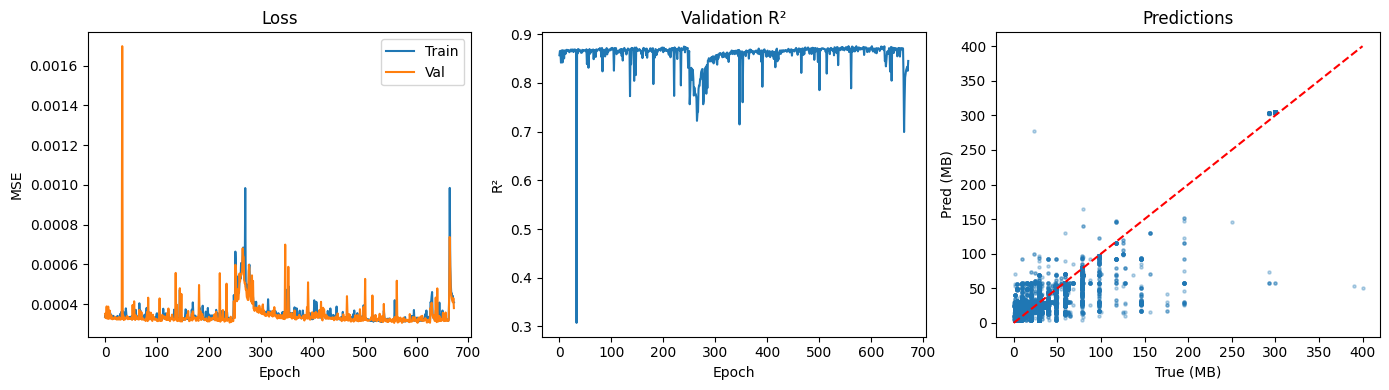


📊 Final: RMSE=7.0 MB, R²=0.8754


In [22]:
# Visualize Results
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["val_loss"], label="Val")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("MSE"); axes[0].legend(); axes[0].set_title("Loss")

axes[1].plot(history["val_r2"])
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("R²"); axes[1].set_title("Validation R²")

# Predictions
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        all_preds.extend(model(xb.to(device)).cpu().numpy())
        all_targets.extend(yb.numpy())
all_preds = np.array(all_preds) * (y_max - y_min) + y_min
all_targets = np.array(all_targets) * (y_max - y_min) + y_min

axes[2].scatter(all_targets, all_preds, alpha=0.3, s=5)
axes[2].plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
axes[2].set_xlabel("True (MB)"); axes[2].set_ylabel("Pred (MB)"); axes[2].set_title("Predictions")

plt.tight_layout(); plt.show()

print(f"\n📊 Final: RMSE={np.sqrt(mean_squared_error(all_targets, all_preds)):.1f} MB, R²={r2_score(all_targets, all_preds):.4f}")